In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def load_train_data():
    df = pd.read_csv("train.tsv", delimiter="\t")
    return df

df0 = load_train_data()
df0.head()

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,29.0,4,135.0,84.00,2525.0,16.0,82,1,dodge aries se
1,3,31.9,4,89.0,71.00,1925.0,14.0,79,2,vw rabbit custom
2,9,19.0,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii
3,11,28.0,4,90.0,75.00,2125.0,14.5,74,1,dodge colt
4,13,37.7,4,89.0,62.00,2050.0,17.3,81,3,toyota tercel


In [3]:
df0.dtypes

id                int64
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [4]:
# 文字列になっている、horsepowerおよびcar nameをそれぞれint64に変換する
# 上記変換前にcar nameはcategory_encoderで変換する

import category_encoders as ce

In [22]:
list_col = ["car name"]

def do_category_encoding(df, list_cols):
    ce_oe = ce.OrdinalEncoder(cols=list_cols, handle_unknown="impute")
    df_encoding = ce_oe.fit_transform(df)
    return df_encoding, ce_oe

df_ce0, ce_oe = do_category_encoding(df0, list_col)
df_ce0.head()    

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,29.0,4,135.0,84.00,2525.0,16.0,82,1,1
1,3,31.9,4,89.0,71.00,1925.0,14.0,79,2,2
2,9,19.0,6,156.0,108.0,2930.0,15.5,76,3,3
3,11,28.0,4,90.0,75.00,2125.0,14.5,74,1,4
4,13,37.7,4,89.0,62.00,2050.0,17.3,81,3,5


In [6]:
df_ce0["horsepower"].unique()

array(['84.00', '71.00', '108.0', '75.00', '62.00', '90.00', '105.0',
       '180.0', '113.0', '135.0', '120.0', '88.00', '165.0', '100.0',
       '69.00', '70.00', '60.00', '80.00', '132.0', '85.00', '130.0',
       '93.00', '?', '175.0', '68.00', '58.00', '110.0', '65.00', '67.00',
       '78.00', '48.00', '112.0', '86.00', '83.00', '81.00', '82.00',
       '92.00', '97.00', '76.00', '193.0', '148.0', '72.00', '170.0',
       '140.0', '220.0', '79.00', '198.0', '150.0', '64.00', '96.00',
       '138.0', '52.00', '145.0', '95.00', '160.0', '74.00', '54.00',
       '149.0', '139.0', '129.0', '63.00', '122.0', '200.0', '46.00',
       '153.0', '89.00', '155.0', '61.00', '215.0', '190.0', '115.0'],
      dtype=object)

In [7]:
# horsepowerに含まれる?の部分のデータを抽出。全体に対してどの程度含まれるか確認

df_ce0[df_ce0["horsepower"] == "?"]

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
24,48,23.0,4,151.0,?,3035.0,20.5,82,1,25
113,234,34.5,4,100.0,?,2320.0,15.8,81,2,103
145,288,40.9,4,85.0,?,1835.0,17.3,80,2,130
175,349,25.0,4,98.0,?,2046.0,19.0,71,1,21


In [8]:
# まずは?の分を削除
df_ce1 = df_ce0[df_ce0["horsepower"] != "?"]

df_ce1.dtypes

id                int64
mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car name          int64
dtype: object

In [9]:
# horsepowerをfloatに変化する

def change_data_type_of_horsepower(df):
    df["horsepower"] = df["horsepower"].astype(float)
    return df

df_ce = change_data_type_of_horsepower(df_ce1)
df_ce.dtypes

/tmp/ipykernel_4610/1930891719.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["horsepower"] = df["horsepower"].astype(float)


id                int64
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year        int64
origin            int64
car name          int64
dtype: object

In [10]:
def split_Xy(df):
    X = df.drop("mpg", axis=1)
    y = df["mpg"]
    return X, y

X, y = split_Xy(df_ce)

print(X.columns)
print(y.head())

Index(['id', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')
0    29.0
1    31.9
2    19.0
3    28.0
4    37.7
Name: mpg, dtype: float64


In [11]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [13]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [14]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の評価関数
          'learning_rate': 0.1,         # 学習率
          }

In [16]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_val], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  )  

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 23.437821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [17]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

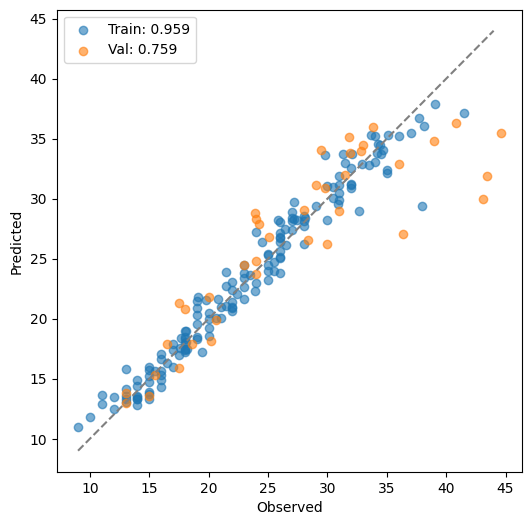

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_pred_train, alpha=0.6, label="Train: %.3f" %r2_train)
plt.scatter(y_val, y_pred_val, alpha=0.6, label="Val: %.3f" %r2_val)
plt.plot(np.arange(min(y),max(y)),np.arange(min(y),max(y)), linestyle="dashed", color="gray")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.legend()

In [21]:
X_test = pd.read_csv("test.tsv", delimiter="\t")
X_test.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,1,6,145.0,76.00,3160.0,19.6,81,2,volvo diesel
1,2,6,250.0,98.00,3525.0,19.0,77,1,ford granada
2,4,4,119.0,92.00,2434.0,15.0,80,3,datsun 510 hatchback
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw)
4,6,4,97.0,88.00,2100.0,16.5,72,3,toyota corolla 1600 (sw)


In [23]:
X_test.dtypes

id                int64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [24]:
def do_preprocess_for_test(ce_oe, X_test):
    # category encoding
    X_test0 = ce_oe.fit_transform(X_test)
    # change data type of horsepower from object to integer
    X_test0["horsepower"] = X_test0["horsepower"].astype(float)
    return X_test0

X_test0 = do_preprocess_for_test(ce_oe, X_test)
X_test0.head()

ValueError: could not convert string to float: '?'

In [25]:
# test.tsvにも?が入っているかを確認
X_test["horsepower"].unique()

array(['76.00', '98.00', '92.00', '110.0', '88.00', '90.00', '150.0',
       '105.0', '190.0', '75.00', '175.0', '65.00', '87.00', '77.00',
       '140.0', '67.00', '48.00', '170.0', '155.0', '84.00', '70.00',
       '60.00', '95.00', '215.0', '52.00', '180.0', '71.00', '49.00',
       '68.00', '63.00', '103.0', '85.00', '80.00', '152.0', '58.00',
       '79.00', '86.00', '78.00', '?', '100.0', '69.00', '145.0', '230.0',
       '125.0', '115.0', '130.0', '198.0', '94.00', '153.0', '83.00',
       '208.0', '46.00', '137.0', '142.0', '72.00', '102.0', '81.00',
       '66.00', '165.0', '160.0', '225.0', '97.00', '53.00', '120.0',
       '167.0', '210.0', '74.00', '129.0', '133.0', '158.0', '107.0',
       '116.0', '91.00'], dtype=object)

In [ ]:
# 残念ながらtestにも?が含まれているっぽい…

In [29]:
X_test_temp = X_test[X_test["horsepower"] != "?"]
X_test_temp["horsepower"] = X_test_temp["horsepower"].astype(float)

/tmp/ipykernel_4610/3607914602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_temp["horsepower"] = X_test_temp["horsepower"].astype(float)


(array([[10., 48., 59., 22.,  8., 26.,  7.,  8.,  3.,  6.],
        [17., 47., 61., 22., 11., 21.,  6.,  6.,  2.,  2.]]),
 array([ 46. ,  64.4,  82.8, 101.2, 119.6, 138. , 156.4, 174.8, 193.2,
        211.6, 230. ]),
 <a list of 2 BarContainer objects>)

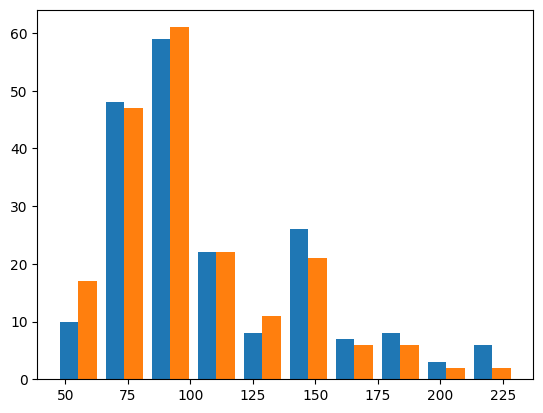

In [30]:
# trainとtestのhorsepowerの分布を調査
plt.hist([X_test_temp["horsepower"], df_ce["horsepower"]])

In [33]:
# trainのうち"?"が含まれているもの
df0[df0["horsepower"] == "?"]

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
24,48,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl
113,234,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
145,288,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
175,349,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto


In [32]:
# testのうち"?"が含まれているもの
X_test[X_test["horsepower"] == "?"]

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
70,138,6,200.0,?,2875.0,17.0,74,1,ford maverick
112,221,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra


In [36]:
# そもそも、testに含まれるford maverickやford mustang cobraはtrainに含まれている？
print(df0[df0["car name"] == "ford maverick"])
print(df0[df0["car name"] == "ford mustang cobra"])

Empty DataFrame
Columns: [id, mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin, car name]
Index: []
Empty DataFrame
Columns: [id, mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin, car name]
Index: []


In [43]:
# trainに含まれるcar name
X_test[X_test["horsepower"] == "?"]["car name"].values

array(['ford maverick', 'ford mustang cobra'], dtype=object)

In [47]:
for name in X_test[X_test["horsepower"] == "?"]["car name"].values:
    if name in df0["car name"].values:
        print(name, "is in train dataset.")
    else:
        print(name, "is NOT in train dataset.")

ford maverick is NOT in train dataset.
ford mustang cobra is NOT in train dataset.


---
### 分かったこと
- train.tsv、および、test.tsvには"?"が含まれている -> 単純に削除して解析してはいけない
- train.tsv、および、test.tsvのhorsepowerの分布は比較的似ている -> "?"は平均値で代用する
- test.tsvに含まれるcar nameは、train.tsvには含まれていない -> car nameは解析に加える必要がないかもしれない